In [ ]:
import sys
!{sys.executable} -m pip install wordcloud
!{sys.executable} -m pip install pandas

In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.\
        builder.\
        appName("pyspark-notebook").\
        master("spark://spark-master:7077").\
        config("spark.executor.memory", "1g").\
        getOrCreate()

22/01/23 22:17:00 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [6]:
from pyspark.sql.functions import split, explode, col, desc
from pyspark.sql.types import StringType
from pyspark.sql import functions 
import pandas
import glob

list_files = sorted(glob.glob("data/*.gz"))

for idx, file in enumerate(list_files):
    df = spark.read.option("header", "true").csv(file)
    df = df.where(col("text").isNotNull())
    df = df.withColumn("text",col("text").cast(StringType()))
    df = df.where(col("country_code") == "US")
    words = df.select(explode(split("text", "\\s+")).alias("words"), "user_id").where(col("text").startswith("#"))
    words = words.select("words", "user_id").alias("words").where(col("words").startswith("#"))
    words = words.select("user_id").distinct().where( (col("words") == "#Covid19")
                                                    | (col("words") == "#Covid_19")
                                                    | (col("words") == "#coronavirus")
                                                    | (col("words") == "#covid19")).count()
    if idx == 0:
        trendCount = spark.createDataFrame([{"idx": str(idx), "trends": str(words)}])
    else:
        df = spark.createDataFrame([{"idx": str(idx), "trends": str(words)}])
        trendCount = trendCount.union(df)

/usr/local/lib/python3.9/dist-packages/pyspark/sql/session.py:378: UserWarning: inferring schema from dict is deprecated,please use pyspark.sql.Row instead
  warnings.warn("inferring schema from dict is deprecated,"


In [7]:
from datetime import datetime, timedelta

trend = trendCount.toPandas()
dates = list()
date = datetime(2020, 4, 3)

values = list()
for day in range(6, 33):
    dates.append(date)
    date = date + timedelta(days=1)
    idx= day-6
    soma = 0
    for i in range(idx, day):
        soma += int(trend.iloc[i,1])
    values.append(soma/6)

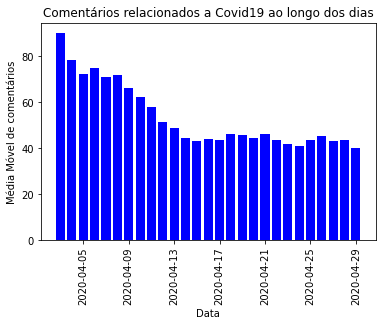

In [8]:
import matplotlib.pyplot as plt
from datetime import datetime, timedelta    

plt.bar(dates, values, color='blue')
plt.xlabel("Data")
plt.xticks(rotation='vertical')
plt.ylabel("Média Móvel de comentários")
plt.title("Comentários relacionados a Covid19 ao longo dos dias")

plt.show()